## MNIST example with BCD and neural implementation

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
np.random.seed(1)
X, y = fetch_openml('mnist_784', version = 1, return_X_y = True) # pandas dataframe
X = X / 255.
X = np.asarray(X)
Y = y.astype(int)

X0, Y0 = X[0:10000,:], Y[0:10000]
X_train, X_test, Y_train, Y_test = train_test_split(X0, Y0, test_size=0.2, random_state=2)
y_train0 = np.where(Y_train == 3, 1, 0)
y_test0 = np.where(Y_test == 3, 1, 0)

/Users/joowonlee/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
# Neural implementation

import torch
import src.SCMF_torch

X_train_torch = src.SCMF_torch.Variable(torch.from_numpy(X_train)).float()
y_train_torch = src.SCMF_torch.Variable(torch.from_numpy(y_train0)).long()
X_test_torch = src.SCMF_torch.Variable(torch.from_numpy(X_test)).float()
y_test_torch = src.SCMF_torch.Variable(torch.from_numpy(y_test0)).long()

scmf_model = src.SCMF_torch.scmf(X_train_torch, y_train_torch, hidden_size = 10, output_size = 1)
results_dict = scmf_model.fit(num_epochs=500,
               lr_classification=0.1,
               lr_matrix_factorization=1,
               xi=1,
               initialize='spectral',
               ini_loading = None,
               ini_code = None,
               W_nonnegativity=True,
               H_nonnegativity=True,
               test_data=[X_test_torch, y_test_torch],
               record_recons_error=True)

--- Training --- [threshold, AUC] =  [0.247, 0.638]
--- Iteration -1: Training loss --- [Data, Label, Total] = [214077.463446.3, 3733.349361.3, 217810.812807.3]
Epoch [10/500],Loss_Classification: 6840.0513 Loss_MF: 0.0822
mythre= 0.24700604
mythre_test= 0.091526486
Test accuracy = 0.947, Test AUC = 0.965
--- Training --- [threshold, AUC] =  [0.105, 0.954]
--- Iteration 9: Training loss --- [Data, Label, Total] = [513435.487970.3, 1054.464444.3, 514489.952414.3]
Epoch [20/500],Loss_Classification: 6840.0513 Loss_MF: 0.0791
mythre= 0.10475183
mythre_test= 0.091526486
Test accuracy = 0.929, Test AUC = 0.965
--- Training --- [threshold, AUC] =  [0.105, 0.954]
--- Iteration 19: Training loss --- [Data, Label, Total] = [494346.743361.3, 1054.464444.3, 495401.207805.3]
Epoch [30/500],Loss_Classification: 6840.0513 Loss_MF: 0.0766
mythre= 0.10475183
mythre_test= 0.091526486
Test accuracy = 0.929, Test AUC = 0.965
--- Training --- [threshold, AUC] =  [0.105, 0.954]
--- Iteration 29: Training l

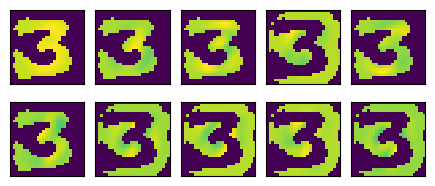

[[-3.426036   0.9374258  2.5996926 -1.7615857 -2.2773795  1.9342525
   0.6488114 -2.3625405 -0.6389883 -2.0236495 -1.4767333]]


In [5]:
src.SCMF_torch.display_dictionary(results_dict["loading"][0], grid_shape = [2,5])
print(results_dict["loading"][1])

In [8]:
# BCD implementation

import src.SCMF_BCD

r = 10
W0_H, W0_W, H0 = src.SCMF_torch.find_initial(X_train.T, y_train0.reshape(1, -1), r = r, generate="spectral")

SMF_BCD_class = src.SCMF_BCD.SMF_BCD(X=[X_train.T, y_train0.reshape(1, -1)],  # data, label
                                    X_test=[X_test.T, y_test0.reshape(1, -1)],
                                    n_components=r,  # =: r = number of columns in dictionary matrices W, W'
                                    ini_loading=W0_W,  # Initializatio for [W,W'], W1.shape = [d1, r], W2.shape = [d2, r]
                                    ini_code = H0,
                                    xi=1,  # weight on label reconstruction error
                                    L1_reg = [0,0,0], # L1 regularizer for code H, dictionary W[0], reg param W[1]
                                    L2_reg = [0,0,0], # L2 regularizer for code H, dictionary W[0], reg param W[1]
                                    nonnegativity=[True,True,False], # nonnegativity constraints on code H, dictionary W[0], reg params W[1]
                                    full_dim=False) # if true, dictionary is Id with full dimension --> Pure regression

results_dict_new = SMF_BCD_class.fit(iter=500, subsample_size=None,
                                        beta = 0,
                                        option = "filter",
                                        search_radius_const=0.1,
                                        update_nuance_param=False,
                                        if_compute_recons_error=True, if_validate=True)

results_dict_new.update({'method': 'SMF-filt'})
results_dict_new.update({'Accuracy': round(results_dict.get('Accuracy'),3)})
results_dict_new.update({'F_score': round(results_dict.get('F_score'),3)})

/Users/joowonlee/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/joowonlee/miniforge3/envs/tf/lib/python3.9/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


initial loading beta [[-3.79471554e+00 -3.17213463e-04  2.41281670e-03  4.28282880e-03
   7.13156794e-03  5.39494217e-03  7.98426873e-04 -3.28086276e-03
   1.05864323e-02 -2.60112319e-03 -3.91201011e-04]]


  0%|                                           | 1/500 [00:00<04:00,  2.08it/s]

--- Training --- [threshold, AUC] =  [0.141, 0.943]
--- Iteration 0: Training loss --- [Data, Label, Total] = [704184.116026.3, 1223.316757.3, 705407.432783.3]


  2%|▊                                         | 10/500 [00:03<03:01,  2.70it/s]

--- Training --- [threshold, AUC] =  [0.122, 0.979]
--- Iteration 10: Training loss --- [Data, Label, Total] = [700969.301378.3, 696.834282.3, 701666.135660.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.122, 0.979]


  2%|▉                                         | 11/500 [00:04<06:24,  1.27it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.122, 0.98, 0.957, 0.831]


  4%|█▋                                        | 20/500 [00:07<02:15,  3.54it/s]

--- Training --- [threshold, AUC] =  [0.13, 0.979]
--- Iteration 20: Training loss --- [Data, Label, Total] = [698349.535260.3, 680.755818.3, 699030.291078.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.13, 0.979]


  4%|█▊                                        | 21/500 [00:08<05:09,  1.55it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.139, 0.981, 0.958, 0.832]


  6%|██▌                                       | 30/500 [00:12<02:41,  2.91it/s]

--- Training --- [threshold, AUC] =  [0.136, 0.98]
--- Iteration 30: Training loss --- [Data, Label, Total] = [696040.313232.3, 682.913597.3, 696723.226829.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.136, 0.98]


  6%|██▌                                       | 31/500 [00:13<04:47,  1.63it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.131, 0.981, 0.96, 0.838]


  8%|███▎                                      | 40/500 [00:16<02:29,  3.07it/s]

--- Training --- [threshold, AUC] =  [0.134, 0.979]
--- Iteration 40: Training loss --- [Data, Label, Total] = [693959.826253.3, 691.092208.3, 694650.918462.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.134, 0.979]


  8%|███▍                                      | 41/500 [00:18<05:19,  1.44it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.163, 0.981, 0.956, 0.826]


 10%|████▏                                     | 50/500 [00:21<02:40,  2.80it/s]

--- Training --- [threshold, AUC] =  [0.131, 0.979]
--- Iteration 50: Training loss --- [Data, Label, Total] = [692053.590990.3, 701.585649.3, 692755.176639.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.131, 0.979]


 10%|████▎                                     | 51/500 [00:23<05:45,  1.30it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.168, 0.981, 0.952, 0.813]


 12%|█████                                     | 60/500 [00:27<03:04,  2.39it/s]

--- Training --- [threshold, AUC] =  [0.142, 0.979]
--- Iteration 60: Training loss --- [Data, Label, Total] = [690315.269940.3, 707.295160.3, 691022.565100.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.142, 0.979]


 12%|█████                                     | 61/500 [00:29<05:28,  1.34it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.17, 0.981, 0.957, 0.829]


 14%|█████▉                                    | 70/500 [00:32<02:37,  2.72it/s]

--- Training --- [threshold, AUC] =  [0.132, 0.979]
--- Iteration 70: Training loss --- [Data, Label, Total] = [688695.372887.3, 715.326831.3, 689410.699718.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.132, 0.979]


 14%|█████▉                                    | 71/500 [00:34<05:01,  1.42it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.17, 0.981, 0.95, 0.808]


 16%|██████▋                                   | 80/500 [00:37<02:39,  2.63it/s]

--- Training --- [threshold, AUC] =  [0.131, 0.979]
--- Iteration 80: Training loss --- [Data, Label, Total] = [687134.240288.3, 720.066066.3, 687854.306354.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.131, 0.979]


 16%|██████▊                                   | 81/500 [00:39<05:01,  1.39it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.166, 0.981, 0.95, 0.806]


 18%|███████▌                                  | 90/500 [00:42<02:40,  2.56it/s]

--- Training --- [threshold, AUC] =  [0.137, 0.979]
--- Iteration 90: Training loss --- [Data, Label, Total] = [685612.331982.3, 723.230913.3, 686335.562894.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.137, 0.979]


 18%|███████▋                                  | 91/500 [00:44<04:42,  1.45it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.168, 0.981, 0.953, 0.816]


 20%|████████▏                                | 100/500 [00:47<02:32,  2.62it/s]

--- Training --- [threshold, AUC] =  [0.136, 0.979]
--- Iteration 100: Training loss --- [Data, Label, Total] = [684130.732983.3, 727.286936.3, 684858.019919.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.136, 0.979]


 20%|████████▎                                | 101/500 [00:48<04:51,  1.37it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.167, 0.981, 0.952, 0.812]


 22%|█████████                                | 110/500 [00:52<02:42,  2.40it/s]

--- Training --- [threshold, AUC] =  [0.136, 0.978]
--- Iteration 110: Training loss --- [Data, Label, Total] = [682701.430393.3, 732.405279.3, 683433.835672.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.136, 0.978]


 22%|█████████                                | 111/500 [00:54<04:44,  1.37it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.16, 0.98, 0.951, 0.81]


 24%|█████████▊                               | 120/500 [00:57<02:17,  2.77it/s]

--- Training --- [threshold, AUC] =  [0.141, 0.978]
--- Iteration 120: Training loss --- [Data, Label, Total] = [681297.458637.3, 736.317507.3, 682033.776144.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.141, 0.978]


 24%|█████████▉                               | 121/500 [00:58<04:17,  1.47it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.188, 0.98, 0.954, 0.819]


 26%|██████████▋                              | 130/500 [01:01<02:13,  2.77it/s]

--- Training --- [threshold, AUC] =  [0.143, 0.978]
--- Iteration 130: Training loss --- [Data, Label, Total] = [679908.783423.3, 739.834786.3, 680648.618209.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.143, 0.978]


 26%|██████████▋                              | 131/500 [01:03<04:12,  1.46it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.19, 0.98, 0.956, 0.826]


 28%|███████████▍                             | 140/500 [01:06<02:07,  2.82it/s]

--- Training --- [threshold, AUC] =  [0.153, 0.978]
--- Iteration 140: Training loss --- [Data, Label, Total] = [678552.399172.3, 743.251668.3, 679295.650840.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.153, 0.978]


 28%|███████████▌                             | 141/500 [01:07<04:11,  1.43it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.19, 0.98, 0.958, 0.83]


 30%|████████████▎                            | 150/500 [01:10<02:00,  2.90it/s]

--- Training --- [threshold, AUC] =  [0.151, 0.978]
--- Iteration 150: Training loss --- [Data, Label, Total] = [677216.673831.3, 746.264392.3, 677962.938224.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.151, 0.978]


 30%|████████████▍                            | 151/500 [01:12<04:01,  1.44it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.189, 0.98, 0.957, 0.828]


 32%|█████████████                            | 160/500 [01:16<02:38,  2.14it/s]

--- Training --- [threshold, AUC] =  [0.149, 0.978]
--- Iteration 160: Training loss --- [Data, Label, Total] = [675899.547525.3, 749.265493.3, 676648.813018.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.149, 0.978]


 32%|█████████████▏                           | 161/500 [01:18<04:25,  1.28it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.147, 0.98, 0.956, 0.825]


 34%|█████████████▉                           | 170/500 [01:22<03:16,  1.68it/s]

--- Training --- [threshold, AUC] =  [0.15, 0.978]
--- Iteration 170: Training loss --- [Data, Label, Total] = [674600.161329.3, 752.019885.3, 675352.181214.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.15, 0.978]


 34%|██████████████                           | 171/500 [01:25<07:40,  1.40s/it]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.189, 0.98, 0.956, 0.825]


 36%|██████████████▊                          | 180/500 [01:30<02:16,  2.34it/s]

--- Training --- [threshold, AUC] =  [0.149, 0.978]
--- Iteration 180: Training loss --- [Data, Label, Total] = [673317.530819.3, 754.622744.3, 674072.153563.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.149, 0.978]


 36%|██████████████▊                          | 181/500 [01:32<03:39,  1.45it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.147, 0.98, 0.956, 0.825]


 38%|███████████████▌                         | 190/500 [01:34<01:32,  3.35it/s]

--- Training --- [threshold, AUC] =  [0.13, 0.977]
--- Iteration 190: Training loss --- [Data, Label, Total] = [672053.614996.3, 757.239723.3, 672810.854718.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.13, 0.977]


 38%|███████████████▋                         | 191/500 [01:36<03:23,  1.52it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.145, 0.98, 0.946, 0.795]


 40%|████████████████▍                        | 200/500 [01:39<01:27,  3.42it/s]

--- Training --- [threshold, AUC] =  [0.145, 0.977]
--- Iteration 200: Training loss --- [Data, Label, Total] = [670804.963594.3, 759.734478.3, 671564.698072.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.145, 0.977]


 40%|████████████████▍                        | 201/500 [01:42<05:31,  1.11s/it]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.189, 0.98, 0.956, 0.824]


 42%|█████████████████▏                       | 210/500 [01:46<02:03,  2.36it/s]

--- Training --- [threshold, AUC] =  [0.145, 0.977]
--- Iteration 210: Training loss --- [Data, Label, Total] = [669570.642582.3, 762.143378.3, 670332.785960.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.145, 0.977]


 42%|█████████████████▎                       | 211/500 [01:47<03:41,  1.31it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.189, 0.98, 0.956, 0.824]


 44%|██████████████████                       | 220/500 [01:51<01:49,  2.56it/s]

--- Training --- [threshold, AUC] =  [0.144, 0.977]
--- Iteration 220: Training loss --- [Data, Label, Total] = [668349.652121.3, 764.461733.3, 669114.113854.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.144, 0.977]


 44%|██████████████████                       | 221/500 [01:52<03:18,  1.41it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.187, 0.98, 0.954, 0.819]


 46%|██████████████████▊                      | 230/500 [01:55<01:35,  2.83it/s]

--- Training --- [threshold, AUC] =  [0.161, 0.977]
--- Iteration 230: Training loss --- [Data, Label, Total] = [667141.350474.3, 766.703806.3, 667908.054280.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.161, 0.977]


 46%|██████████████████▉                      | 231/500 [01:56<02:55,  1.53it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.185, 0.98, 0.96, 0.838]


 48%|███████████████████▋                     | 240/500 [01:59<01:31,  2.84it/s]

--- Training --- [threshold, AUC] =  [0.161, 0.977]
--- Iteration 240: Training loss --- [Data, Label, Total] = [665945.032349.3, 768.871156.3, 666713.903505.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.161, 0.977]


 48%|███████████████████▊                     | 241/500 [02:01<02:51,  1.51it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.157, 0.98, 0.96, 0.838]


 50%|████████████████████▌                    | 250/500 [02:04<01:27,  2.87it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.977]
--- Iteration 250: Training loss --- [Data, Label, Total] = [664760.182221.3, 770.957579.3, 665531.139800.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.977]


 50%|████████████████████▌                    | 251/500 [02:05<02:46,  1.50it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.158, 0.98, 0.963, 0.848]


 52%|█████████████████████▎                   | 260/500 [02:08<01:20,  3.00it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.977]
--- Iteration 260: Training loss --- [Data, Label, Total] = [663586.217384.3, 772.992428.3, 664359.209812.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.977]


 52%|█████████████████████▍                   | 261/500 [02:10<02:32,  1.57it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.158, 0.98, 0.963, 0.848]


 54%|██████████████████████▏                  | 270/500 [02:13<01:21,  2.82it/s]

--- Training --- [threshold, AUC] =  [0.173, 0.977]
--- Iteration 270: Training loss --- [Data, Label, Total] = [662422.688314.3, 774.970421.3, 663197.658735.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.173, 0.977]


 54%|██████████████████████▏                  | 271/500 [02:14<02:34,  1.48it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.962, 0.844]


 56%|██████████████████████▉                  | 280/500 [02:17<01:20,  2.75it/s]

--- Training --- [threshold, AUC] =  [0.175, 0.977]
--- Iteration 280: Training loss --- [Data, Label, Total] = [661269.129068.3, 776.876353.3, 662046.005421.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.175, 0.977]


 56%|███████████████████████                  | 281/500 [02:19<02:26,  1.50it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.16, 0.98, 0.963, 0.848]


 58%|███████████████████████▊                 | 290/500 [02:22<01:13,  2.86it/s]

--- Training --- [threshold, AUC] =  [0.176, 0.977]
--- Iteration 290: Training loss --- [Data, Label, Total] = [660125.145811.3, 778.769947.3, 660903.915758.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.176, 0.977]


 58%|███████████████████████▊                 | 291/500 [02:23<02:17,  1.52it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.16, 0.98, 0.962, 0.845]


 60%|████████████████████████▌                | 300/500 [02:26<01:08,  2.93it/s]

--- Training --- [threshold, AUC] =  [0.176, 0.977]
--- Iteration 300: Training loss --- [Data, Label, Total] = [658990.415602.3, 780.589895.3, 659771.005497.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.176, 0.977]


 60%|████████████████████████▋                | 301/500 [02:27<02:14,  1.48it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.16, 0.98, 0.962, 0.844]


 62%|█████████████████████████▍               | 310/500 [02:30<01:02,  3.02it/s]

--- Training --- [threshold, AUC] =  [0.176, 0.976]
--- Iteration 310: Training loss --- [Data, Label, Total] = [657864.536338.3, 782.381956.3, 658646.918294.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.176, 0.976]


 62%|█████████████████████████▌               | 311/500 [02:32<01:59,  1.58it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.16, 0.98, 0.962, 0.842]


 64%|██████████████████████████▏              | 320/500 [02:36<02:03,  1.46it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.976]
--- Iteration 320: Training loss --- [Data, Label, Total] = [656747.260106.3, 784.111645.3, 657531.371752.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.976]


 64%|██████████████████████████▎              | 321/500 [02:38<02:59,  1.01s/it]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.16, 0.98, 0.961, 0.84]


 66%|███████████████████████████              | 330/500 [02:41<00:47,  3.57it/s]

--- Training --- [threshold, AUC] =  [0.176, 0.976]
--- Iteration 330: Training loss --- [Data, Label, Total] = [655638.266440.3, 785.814607.3, 656424.081047.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.176, 0.976]


 66%|███████████████████████████▏             | 331/500 [02:44<02:58,  1.06s/it]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.16, 0.98, 0.961, 0.84]


 68%|███████████████████████████▉             | 340/500 [02:47<01:05,  2.44it/s]

--- Training --- [threshold, AUC] =  [0.175, 0.976]
--- Iteration 340: Training loss --- [Data, Label, Total] = [654537.295728.3, 787.485655.3, 655324.781383.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.175, 0.976]


 68%|███████████████████████████▉             | 341/500 [02:48<01:50,  1.44it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.16, 0.98, 0.961, 0.84]


 70%|████████████████████████████▋            | 350/500 [02:52<00:58,  2.57it/s]

--- Training --- [threshold, AUC] =  [0.175, 0.976]
--- Iteration 350: Training loss --- [Data, Label, Total] = [653444.126512.3, 789.122981.3, 654233.249493.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.175, 0.976]


 70%|████████████████████████████▊            | 351/500 [02:53<01:42,  1.45it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.96, 0.838]


 72%|█████████████████████████████▌           | 360/500 [02:56<00:49,  2.81it/s]

--- Training --- [threshold, AUC] =  [0.175, 0.976]
--- Iteration 360: Training loss --- [Data, Label, Total] = [652358.520648.3, 790.722696.3, 653149.243344.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.175, 0.976]


 72%|█████████████████████████████▌           | 361/500 [02:58<01:33,  1.48it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.96, 0.838]


 74%|██████████████████████████████▎          | 370/500 [03:01<00:44,  2.95it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.976]
--- Iteration 370: Training loss --- [Data, Label, Total] = [651280.261895.3, 792.297585.3, 652072.559480.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.976]


 74%|██████████████████████████████▍          | 371/500 [03:02<01:26,  1.49it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.96, 0.838]


 76%|███████████████████████████████▏         | 380/500 [03:05<00:40,  2.99it/s]

--- Training --- [threshold, AUC] =  [0.174, 0.976]
--- Iteration 380: Training loss --- [Data, Label, Total] = [650209.165765.3, 793.845268.3, 651003.011033.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.174, 0.976]


 76%|███████████████████████████████▏         | 381/500 [03:07<01:24,  1.40it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.96, 0.838]


 78%|███████████████████████████████▉         | 390/500 [03:10<00:41,  2.66it/s]

--- Training --- [threshold, AUC] =  [0.173, 0.976]
--- Iteration 390: Training loss --- [Data, Label, Total] = [649145.054112.3, 795.364969.3, 649940.419081.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.173, 0.976]


 78%|████████████████████████████████         | 391/500 [03:11<01:12,  1.50it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.96, 0.838]


 80%|████████████████████████████████▊        | 400/500 [03:15<00:36,  2.73it/s]

--- Training --- [threshold, AUC] =  [0.173, 0.976]
--- Iteration 400: Training loss --- [Data, Label, Total] = [648087.749062.3, 796.863754.3, 648884.612817.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.173, 0.976]


 80%|████████████████████████████████▉        | 401/500 [03:16<01:07,  1.46it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.96, 0.838]


 82%|█████████████████████████████████▌       | 410/500 [03:19<00:32,  2.74it/s]

--- Training --- [threshold, AUC] =  [0.173, 0.976]
--- Iteration 410: Training loss --- [Data, Label, Total] = [647037.099816.3, 798.331382.3, 647835.431198.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.173, 0.976]


 82%|█████████████████████████████████▋       | 411/500 [03:21<00:59,  1.49it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.96, 0.838]


 84%|██████████████████████████████████▍      | 420/500 [03:24<00:28,  2.82it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.976]
--- Iteration 420: Training loss --- [Data, Label, Total] = [645992.954406.3, 799.780891.3, 646792.735297.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


 84%|██████████████████████████████████▌      | 421/500 [03:25<00:55,  1.41it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.961, 0.84]


 86%|███████████████████████████████████▎     | 430/500 [03:30<00:22,  3.05it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.976]
--- Iteration 430: Training loss --- [Data, Label, Total] = [644955.166317.3, 801.207210.3, 645756.373527.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


 86%|███████████████████████████████████▎     | 431/500 [03:31<00:43,  1.57it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.961, 0.84]


 88%|████████████████████████████████████     | 440/500 [03:37<00:24,  2.43it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.976]
--- Iteration 440: Training loss --- [Data, Label, Total] = [643923.608192.3, 802.611044.3, 644726.219236.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


 88%|████████████████████████████████████▏    | 441/500 [03:38<00:41,  1.41it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.159, 0.98, 0.961, 0.84]


 90%|████████████████████████████████████▉    | 450/500 [03:42<00:18,  2.70it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.976]
--- Iteration 450: Training loss --- [Data, Label, Total] = [642898.149678.3, 803.998819.3, 643702.148497.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


 90%|████████████████████████████████████▉    | 451/500 [03:43<00:33,  1.44it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.158, 0.98, 0.961, 0.84]


 92%|█████████████████████████████████████▋   | 460/500 [03:46<00:14,  2.70it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.976]
--- Iteration 460: Training loss --- [Data, Label, Total] = [641878.674566.3, 805.362240.3, 642684.036805.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


 92%|█████████████████████████████████████▊   | 461/500 [03:48<00:26,  1.47it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.158, 0.98, 0.961, 0.84]


 94%|██████████████████████████████████████▌  | 470/500 [03:50<00:10,  2.91it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.976]
--- Iteration 470: Training loss --- [Data, Label, Total] = [640865.063615.3, 806.709131.3, 641671.772746.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


 94%|██████████████████████████████████████▌  | 471/500 [03:52<00:19,  1.51it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.158, 0.98, 0.961, 0.84]


 96%|███████████████████████████████████████▎ | 480/500 [03:55<00:06,  2.92it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.976]
--- Iteration 480: Training loss --- [Data, Label, Total] = [639857.208564.3, 808.036799.3, 640665.245363.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


 96%|███████████████████████████████████████▍ | 481/500 [03:56<00:12,  1.47it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.158, 0.98, 0.961, 0.84]


 98%|████████████████████████████████████████▏| 490/500 [04:00<00:03,  2.75it/s]

--- Training --- [threshold, AUC] =  [0.177, 0.976]
--- Iteration 490: Training loss --- [Data, Label, Total] = [638855.010250.3, 809.353446.3, 639664.363696.3]
!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


 98%|████████████████████████████████████████▎| 491/500 [04:01<00:06,  1.49it/s]

--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.158, 0.98, 0.961, 0.84]


100%|█████████████████████████████████████████| 500/500 [04:04<00:00,  2.04it/s]


!!! pred_type filter
--- Training --- [threshold, AUC] =  [0.177, 0.976]


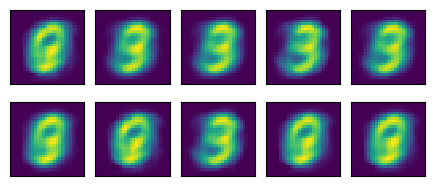

[[-3.51131344 -7.20642683  3.15139288  4.86171342  8.82612072  4.71076809
  -1.80165713 -8.6820064   7.24643632 -5.13798242 -5.06678495]]


In [9]:
src.SCMF_torch.display_dictionary(results_dict_new["loading"][0], grid_shape = [2,5])
print(results_dict_new["loading"][1])